## Hate Speech and Offensive Language Detection Model (Tweet Classification)

### Importing the libraries

Pandas, Numpy, Matplotlib are the basic libraries. Besides these we will need NLTK, Scikit-learn, Tensorflow to make this model work. Let's import them.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import nltk
from nltk.corpus import stopwords

### Be one with data

In [3]:
data = pd.read_csv('../Downloads/hate_speech.csv')
data.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
data.shape

(24783, 6)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   count                     24783 non-null  int64 
 1   hate_speech_count         24783 non-null  int64 
 2   offensive_language_count  24783 non-null  int64 
 3   neither_count             24783 non-null  int64 
 4   class                     24783 non-null  int64 
 5   tweet                     24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [30]:
print(f'Duplicated data in dataset: {data.duplicated().sum()}')

Duplicated data in dataset: 0


In [31]:
print(f'Missing values in dataset: {data.isnull().sum()}')

Missing values in dataset: count                       0
hate_speech_count           0
offensive_language_count    0
neither_count               0
class                       0
tweet                       0
dtype: int64


In [24]:
(data['class'].value_counts())

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

After checking the data we found following results:
- There are 24783 rows in dataset.
- There is 6 columns out of those only one column is Object (string) data type and others are Integer.
- There is no Duplicated values in the dataset.
- There is no missing values in the dataset.
- The data is divided into three class out of that class 1 has most values followed by class 2 and class 0 is the last.


We can also say this, that the data is not vell balanced between the classes. We can try some different methods to balance the data but let's first make the model and check how it is performing.

### Taking out the feature and target 
We will take the feature column (tweet) and target column (class) to use and leave all other columns behind as they are not usable for model.

In [62]:
X = data['tweet'].to_numpy()
y = data['class'].to_numpy()

### Preprocess the data

In [63]:
# Set NLTK Stopwords Language to English
stop_words = set(stopwords.words('english'))

# Remove Retweet in Data
stop_words.add('rt')

# Remove HTML
def remove_html(text):
    html_regex = r'"&[^\s;]+;' 
    clean_text = re.sub(html_regex, '', text)
    return clean_text

# Remove User Tag
def remove_user_tag(text):
    tag_regex = r'@([^ ]+)'
    clean_text = re.sub(tag_regex, 'user', text)
    return clean_text

# Remove URL
def remove_url(text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    clean_text = re.sub(url_regex, '', text)
    return clean_text

def remove_symbols(text):
    clean_text = text.replace('"', '')
    clean_text = clean_text.replace("'", '')
    clean_text = clean_text.replace("!", '')
    clean_text = clean_text.replace("`", '')
    clean_text = clean_text.replace("..", '')
    return clean_text

# Remove Stopwords
def remove_stopwords(text):
    tokenized_words = nltk.word_tokenize(text)
    clean_text = [word for word in tokenized_words if not word.lower() in stop_words]
    clean_text = ' '.join(clean_text)
    return clean_text

# Preprocess the data
def preprocess(data):
    clean_text = []
    clean_text = [remove_user_tag(text) for text in data]
    clean_text = [remove_html(text) for text in clean_text]
    clean_text = [remove_url(text) for text in clean_text]
    clean_text = [remove_symbols(text) for text in clean_text]
    clean_text = [remove_stopwords(text) for text in clean_text]
    return clean_text

In [64]:
clean_X = preprocess(X)
clean_X[:10]

['user woman shouldnt complain cleaning house . & amp ; man always take trash .',
 'user boy dats cold.tyga dwn bad cuffin dat hoe 1st place',
 'user Dawg user ever fuck bitch start cry ? confused shit',
 'user user look like tranny',
 'user shit hear might true might faker bitch told ya & # 57361 ;',
 'user shit blows meclaim faithful somebody still fucking hoes & # 128514 ; & # 128514 ; & # 128514 ;',
 'user sit HATE another bitch got much shit going',
 '& # 8220 ; user cause Im tired big bitches coming us skinny girls & # 8221 ;',
 '& amp ; might get ya bitch back & amp ; thats',
 'user : hobbies include : fighting Mariam bitch']

### Split the data into Train and Text datasets

In [65]:
X_train, X_test, y_train, y_test = train_test_split(clean_X, y, test_size=0.2, random_state=42)

In [66]:
len(X_train), len(X_test), len(y_train), len(y_test)

(19826, 4957, 19826, 4957)

### Turning text to sequence

In [68]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [69]:
# Vocabulary Size
vocab_size = len(tokenizer.word_index) + 1

# Max Length of words 
max_length = max(len(seq) for seq in X_train)

vocab_size, max_length

(18949, 72)

In [70]:
# Uniforming the sequence
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

In [71]:
# Creating OHE for the targets
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

### Create the model

In [91]:
# Output size for embedding layer
output_dim = 200

# Create the model
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=output_dim,
              input_length=max_length),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Fit the model
history = model.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=64,
                    validation_data=(X_test, y_test))

Epoch 1/5
310/310 [==============================] - 87s 262ms/step - loss: 0.4911 - accuracy: 0.8272 - val_loss: 0.3504 - val_accuracy: 0.8786
Epoch 2/5
310/310 [==============================] - 81s 262ms/step - loss: 0.2850 - accuracy: 0.9108 - val_loss: 0.3465 - val_accuracy: 0.8820
Epoch 3/5
310/310 [==============================] - 80s 257ms/step - loss: 0.2001 - accuracy: 0.9285 - val_loss: 0.3923 - val_accuracy: 0.8828
Epoch 4/5
310/310 [==============================] - 81s 261ms/step - loss: 0.1429 - accuracy: 0.9457 - val_loss: 0.5320 - val_accuracy: 0.8721
Epoch 5/5
310/310 [==============================] - 81s 262ms/step - loss: 0.1136 - accuracy: 0.9599 - val_loss: 0.5103 - val_accuracy: 0.8648


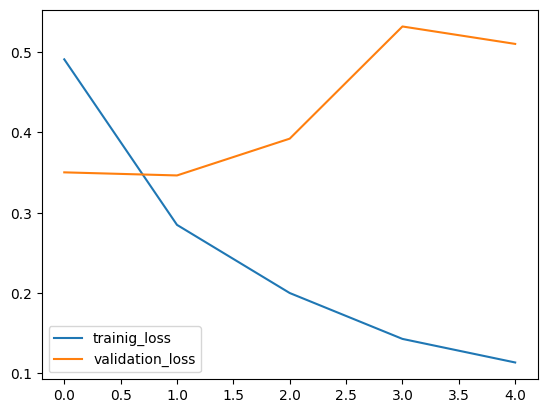

In [92]:
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='trainig_loss')
plt.plot(range(len(history.history['loss'])),history.history['val_loss'], label='validation_loss')
plt.legend()

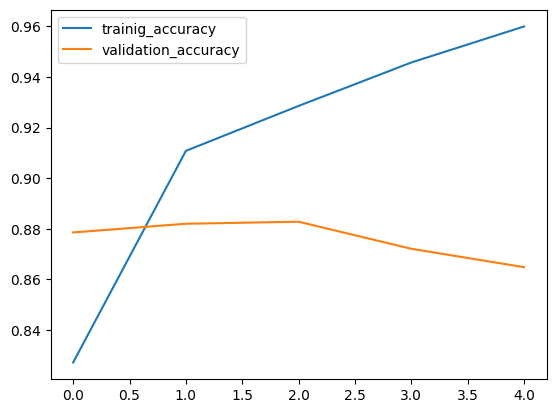

In [93]:
plt.plot(range(len(history.history['accuracy'])),history.history['accuracy'], label='trainig_accuracy')
plt.plot(range(len(history.history['accuracy'])),history.history['val_accuracy'], label='validation_accuracy')
plt.legend()